<center><h1><font color = "#5978a4"> Optimization in data analysis </font></h1></center>

---
<br>
<font color = "#5978a4"> Authors </font> : Daniel Brito, Marcel Affi
<br>
<font color = "#5978a4"> Date </font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: June 2021
<br>
<br>
<br>
<h1> Project Outline </h1>


*   [Preparing datasets](#preparing_datasets)
*   [Implementation](#implementation)
*   [Plots](#plots)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.display import display, HTML

%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
mpl.rcParams['figure.figsize'] = (10,5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['grid.color'] = 'w'
plt.style.use(['ggplot'])

<a id = "preparing_datasets"/>

### Preparing dataset

In [2]:
#Load the diabetes dataset. In this case we will not be using a constant intercept feature
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target.reshape(-1,1)

<a id = "implementation"/>

### Implementation

In [3]:
def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0
    

def coordinate_descent_lasso(theta,X,y,lamda = .01, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    #Initialisation of useful values 
    _,n_coordinates = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n_coordinates):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ theta
            #We compute rho_j to later update the coordinate parameter theta_j
            rho = X_j.T @ (y - y_pred  + theta[j]*X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    #theta_j = S(rho_j, lambda)
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                #theta_j = S(rho_j, lambda)
                theta[j] =  soft_threshold(rho, lamda)
                            
    return theta.flatten()

<a id = "plots"/>

### Plots

(0.06309573444801933, 1584.893192461114, -849.8147108555953, 820.6104516733536)

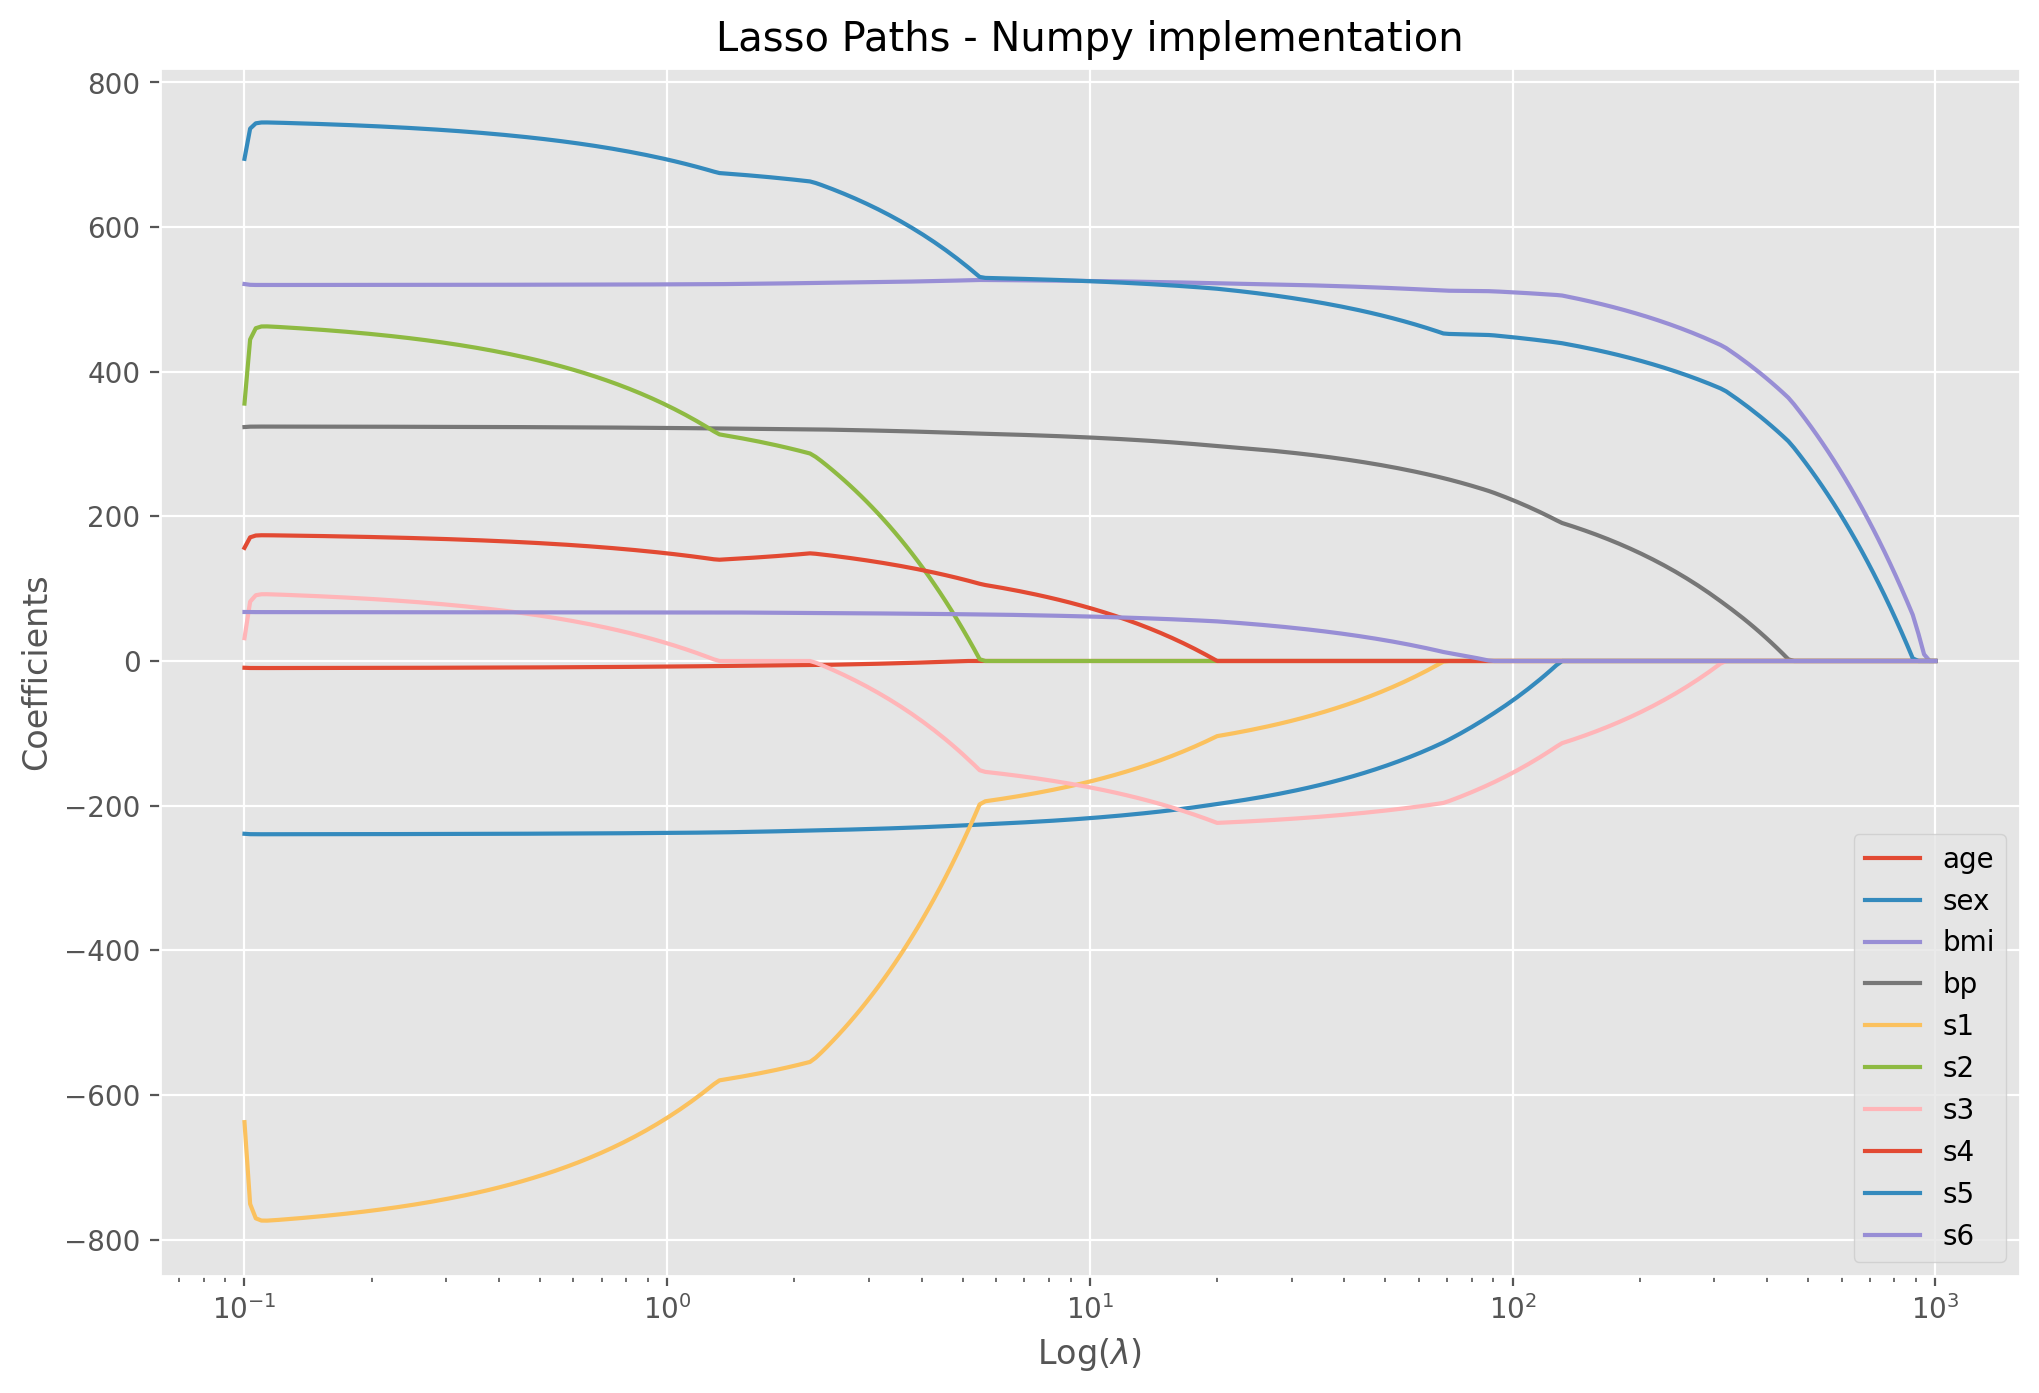

In [4]:
#intercept = np.ones((X.shape[0], 1))
#X = np.concatenate((intercept, X), axis = 1)

m,n = X.shape
initial_theta = np.ones((n,1))

theta_list = list()
lamda = np.logspace(0,4,300)/10 #Range of lambda values
#Run lasso regression for each lambda
for l in lamda:
    theta = coordinate_descent_lasso(initial_theta,X,y,lamda = l, num_iters=100, intercept = False)
    theta_list.append(theta)

#Stack into numpy array
theta_lasso = np.stack(theta_list).T

#Plot results
n,_ = theta_lasso.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, theta_lasso[i], label = diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

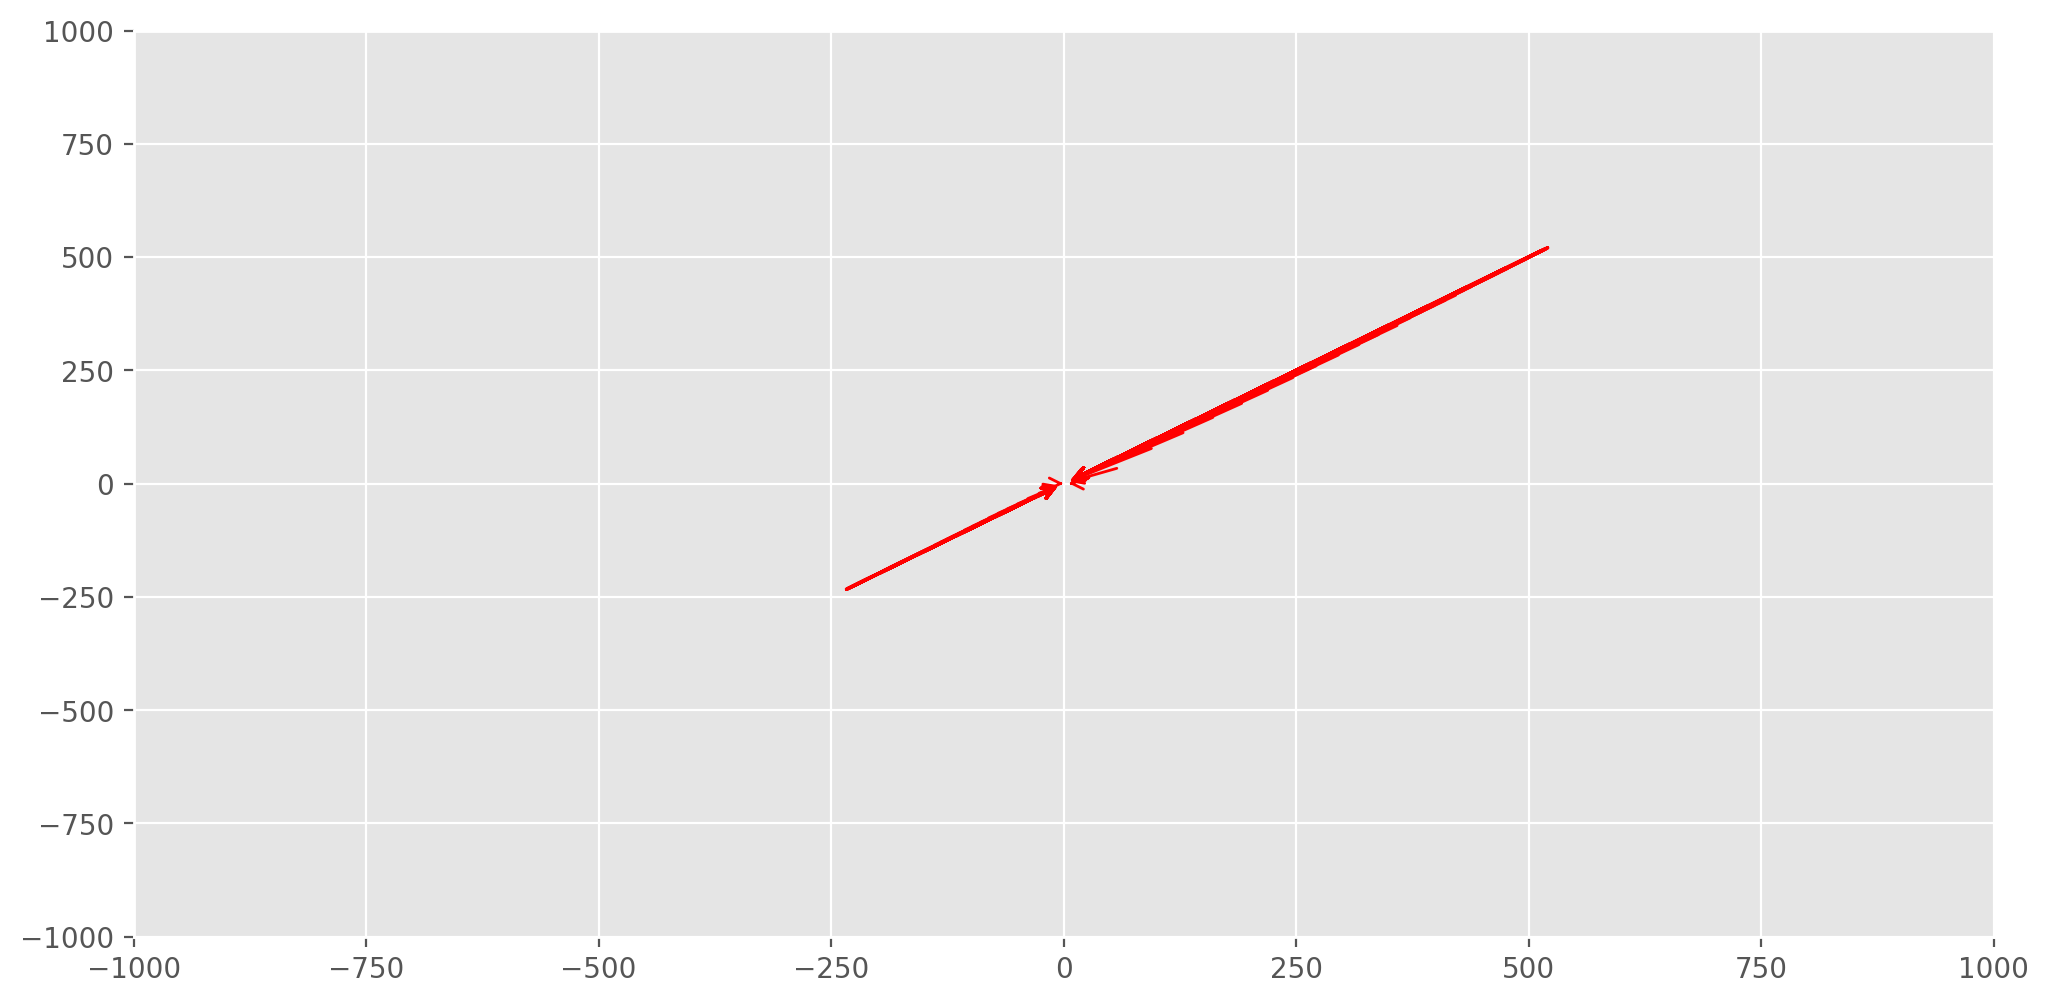

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
for j in range(1,theta_lasso.shape[1]):
    if (j % 2 != 0):
        ax.annotate('', xy=(int(theta_lasso[1][j-1]), int(theta_lasso[1][j])),
                     xytext = (int(theta_lasso[1][j-1])/100, int(theta_lasso[1][j])/100),
                        arrowprops={'arrowstyle': '<-', 'color': 'r', 'lw':1},
                        va='center', ha='center')
    else :
        ax.annotate('', xy=(int(theta_lasso[2][j-1]), int(theta_lasso[2][j])),
                     xytext = (int(theta_lasso[2][j-1])/100, int(theta_lasso[2][j])/100),
                        arrowprops={'arrowstyle': '<-', 'color': 'r', 'lw':1},
                        va='center', ha='center')
    #ax.plot([int(theta_lasso[3][j-1]), int(theta_lasso[3][j-1])], [int(theta_lasso[3][j]), int(theta_lasso[3][j])])
    #print(int(theta_lasso[1][j]), int(theta_lasso[2][j]))
ax.set_xlim([-1000,1000])
ax.set_ylim([-1000,1000])
plt.show()

## Comparing Sklearn to Cyclic and Randomized coordinate descent algorithms

In [6]:
data = "https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv"

In [7]:
class Sklearn:
    """
    This is a demo of using scikit-learn to solve the LASSO problem, that is the `l1-regularized
    least-squares regression problem.

    """

    def __init__(self):
        """
        Using scikit-learn to solve the LASSO problem.

        Parameters
        ----------
        data : str
        A real world data set is being used:
        'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'

        """
        self.data = "https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv"

    def generate_simulate_data(self):
        """
        Generate simulated data sets and standarize data.
        """
        n_samples = 100 ## Number of samples to be taken
        np.random.seed(0)
        #We draw n samples from a Gaussian distribution with mean 1 and standard deviation 1
        X = np.random.normal(loc=1, scale=1, size=n_samples)
        #epsilon will be a random error added to our generated data
        epsilon = np.random.normal(loc=0, scale=0.01, size=n_samples)
        beta0 = 1
        beta1 = 2
        beta2 = 3
        beta3 = 4
        y = beta0 + beta1 * X + beta2 * X ** 2 + beta3 * X ** 3 + epsilon
        predictors = np.vstack([X ** i for i in range(1, 11)]).T
        scaler = preprocessing.StandardScaler()
        #The StandardScaler scales the data by feature by subtracting the population mean and dividing (scaling it) 
        #with the population standard deviation, so our model can be trained by using a homogeneous criteria.
        predictors = scaler.fit_transform(predictors)
        y = y - np.mean(y)
        #We split the predictors into random train and test sets (the train test will be 25% of the predictors array)
        x_train, x_test, y_train, y_test = train_test_split(
            predictors, y, test_size=0.25, random_state=0
        )
        return x_train, x_test, y_train, y_test

    def process_data(self):
        """
        Read and standarize data.
        """
        hitters = pd.read_csv(self.data, sep=",", header=0)
        hitters = hitters.dropna() #Drop column names
        X = hitters.drop("Salary", axis=1)
        X = pd.get_dummies(X, drop_first=True)
        y = hitters.Salary
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, random_state=0
        )  # By default, 25% goes into the test set.
        std_scale = preprocessing.StandardScaler().fit(x_train)
        x_train = std_scale.transform(x_train)
        x_test = std_scale.transform(x_test)
        y_train = preprocessing.scale(y_train, with_mean=True, with_std=False)
        return x_train, x_test, y_train, y_test

    def sklearn_training(self, x, y):
        """
        Using scikit-learn Lasso cross validation to train data
        return optimal lambda and coefficients
        """
        #we load the lasso model and using cross validation we return the optimal lambda and coefficients
        lasso_model = linear_model.LassoCV(
            cv=10, n_alphas=1000, fit_intercept=False, max_iter=1000
        )
        lasso_fit = lasso_model.fit(x, y)
        optimal_alpha = lasso_fit.alpha_
        beta_star = lasso_fit.coef_
        return optimal_alpha, beta_star

In [22]:
class Algorithm:
    """
    This is a demo of using coordinate descent algorithm (including both cyclic coordinate descent
    and randomized coordinate descent) to solve the LASSO problem, that is the `l1-regularized
    least-squares regression problem. The results are being compared with scikit-learn results.

    """

    def __init__(self, lambduh, beta_star, max_iter):
        """
        Coordinate descent algorithm to solve the LASSO problem.

        Parameters
        ----------
        lambduh : float
        Regularization parameter.
        The default lambduh is set as 6.46, the same as optimal lambduh from sklearn, in order to compare
        with sklearn performance.

        data : str
        A real world data set is being used:
        'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'

        max_iter: int
        Default is set as 1000, the same as sklearn, in order to compare
        with sklearn performance.

        """
        self.lambduh = lambduh
        self.beta_star = beta_star
        self.max_iter = max_iter

    def soft_threshold(self, a, lambduh):
        """
        Solving l1-norm gradient problem
        """
        if a < -lambduh:
            return a + lambduh
        elif a > lambduh:
            return a - lambduh
        else:
            return 0

    def min_beta_multivariate(self, x, y, beta, j):
        """
        Solving partial minimization problem with respect to beta_j for any j = 1...d.
        """
        n = len(y)
        selector = [i for i in range(x.shape[1]) if i != j]
        norm_x_j = np.linalg.norm(x[:, j])
        a = x[:, j].dot(
            y[:, np.newaxis]
            - x[:, selector].dot(beta[:, np.newaxis][selector, :])
        )
        passin = self.lambduh * n / 2
        res = self.soft_threshold(a, passin)
        return res / (norm_x_j ** 2)

    def computeobj(self, beta, x, y):
        """
        Compute objective value with certain beta.
        """
        n = len(y)
        return 1 / n * np.sum(
            (y - x.dot(beta)) ** 2
        ) + self.lambduh * np.linalg.norm(beta, ord=1)

    def cycliccoorddescent(self, x, y, beta_init):
        """
        cycliccoorddescent that implements the cyclic coordinate descent algorithm. The cyclic
        coordinate descent algorithm proceeds sequentially. At each iteration, the algorithm
        increments the index j of the coordinate to minimize over. Then the algorithm performs
        partial minimization with respect to the coordinate beta_j corresponding to that index.
        After updating the coordinate beta_j , the algorithm proceeds to the next iteration.
        The function takes as input the initial point, the initial step-size value, and the
        maximum number of iterations. The stopping criterion is the maximum number of iterations.
        """
        beta = copy.deepcopy(beta_init)
        beta_vals = beta
        d = np.size(x, 1)
        iter = 0
        while iter < self.max_iter:
            for j in range(d):
                min_beta_j = self.min_beta_multivariate(x, y, beta, j)
                beta[j] = min_beta_j
            beta_vals = np.vstack((beta_vals, beta))
            iter += 1
            if iter % 100 == 0:
                print("Coordinate descent iteration", iter)
        return beta_vals

    def pickcoord(self, d, j):
        """
        samples uniformly from the set  j = 1...d..
        """
        num = np.random.randint(0, d)
        while num == j:
            num = np.random.randint(0, d)
        return num

    def randcoorddescent(self, x, y, beta_init):
        """
        Randcoorddescent that implements the randomized coordinate descent algorithm. The
        randomized coordinate descent algorithm proceeds as follows. At each iteration,
        the algorithm samples the index j of the coordinate to minimize over. Then the
        algorithm performs partial minimization with respect to the coordinate beta_j
        corresponding to that index. After updating the coordinate beta_j , the algorithm
        proceeds to the next iteration. The function takes as input the initial point,
        the initial step-size value, and the maximum number of iterations. The stopping
        criterion is the maximum number of iterations.
        """
        beta = copy.deepcopy(beta_init)
        beta_vals = beta
        d = np.size(x, 1)
        iter = 0
        while iter < self.max_iter:
            j = -1
            for i in range(d):
                j = self.pickcoord(d, j)
                min_beta_j = self.min_beta_multivariate(x, y, beta, j)
                beta[j] = min_beta_j
            beta_vals = np.vstack((beta_vals, beta))
            iter += 1
            if iter % 100 == 0:
                print("Coordinate descent iteration", iter)
        return beta_vals

    def objective_plot(self, betas_cyclic, betas_rand, x, y, shrink_axis = False):
        """
        Plot the curves of the objective values F(beta_t) for both algorithms versus
        the iteration counter iter (use different colors)
        """
        if shrink_axis :
            num_points = 20
        else :
            num_points = np.size(betas_cyclic, 0)
        objs_cyclic = np.zeros(num_points)
        objs_rand = np.zeros(num_points)
        for i in range(0, num_points):
            objs_cyclic[i] = self.computeobj(betas_cyclic[i, :], x, y)
            objs_rand[i] = self.computeobj(betas_rand[i, :], x, y)
        fig, ax = plt.subplots()
        ax.plot(
            range(1, num_points + 1),
            objs_cyclic,
            label="Cyclic coordinate descent",
            linewidth=5.0,
        )
        ax.plot(
            range(1, num_points + 1),
            objs_rand,
            c="red",
            label="Randomized coordinate descent",
        )
        plt.xlabel("Iteration")
        plt.ylabel("Objective value")
        plt.title(
            "Objective value vs. iteration when lambda=" + str(self.lambduh)
        )
        ax.legend(loc="upper right")
        plt.show()

    def fraction_of_correct_non_zero_coefficients(self, beta_opts):
        """
        Calculate fraction of non zero coefficients of coordinate descent algorithm compared to sklearn
        """
        denom = 0
        nom = 0
        for i in range(len(self.beta_star)):
            if self.beta_star[i] != 0:
                denom += 1
                if (self.beta_star[i] - beta_opts[i]) / self.beta_star[
                    i
                ] < 0.01:
                    nom += 1
        return nom / denom

    def fraction_of_correct_zero_coefficients(self, beta_opts):
        """
        Calculate fraction of zero coefficients of coordinate descent algorithm compared to sklearn
        """
        denom = 0
        nom = 0
        for i in range(len(self.beta_star)):
            if self.beta_star[i] == 0:
                denom += 1
                if beta_opts[i] == 0:
                    nom += 1
        return nom / denom

    def plot_correct_coefficient(
        self, betas_cyclic, betas_rand, f, title, ylabel
    ):
        """
        Plot the curves of fraction of non-zero and zero coefficients of coordinate descent algorithm
        compared to sklearn versus the iteration counter iter
        """
        niter = np.size(betas_cyclic, 0)
        fraction_cyclic = np.zeros(niter)
        fraction_rand = np.zeros(niter)
        for i in range(niter):
            fraction_cyclic[i] = f(betas_cyclic[i, :])
            fraction_rand[i] = f(betas_rand[i, :])
        fig, ax = plt.subplots()

        ax.plot(
            range(1, niter + 1), fraction_cyclic, label="Cyclic", linewidth=5.0
        )
        ax.plot(range(1, niter + 1), fraction_rand, c="red", label="Randmized")
        plt.xlabel("Iteration")
        plt.ylabel(ylabel)
        if title:
            plt.title(title)
        ax.legend(loc="lower right")
        plt.show()

Coordinate descent iteration 100
Coordinate descent iteration 200
Coordinate descent iteration 300
Coordinate descent iteration 400
Coordinate descent iteration 500
Coordinate descent iteration 600
Coordinate descent iteration 700
Coordinate descent iteration 800
Coordinate descent iteration 900
Coordinate descent iteration 1000
Coordinate descent iteration 100
Coordinate descent iteration 200
Coordinate descent iteration 300
Coordinate descent iteration 400
Coordinate descent iteration 500
Coordinate descent iteration 600
Coordinate descent iteration 700
Coordinate descent iteration 800
Coordinate descent iteration 900
Coordinate descent iteration 1000


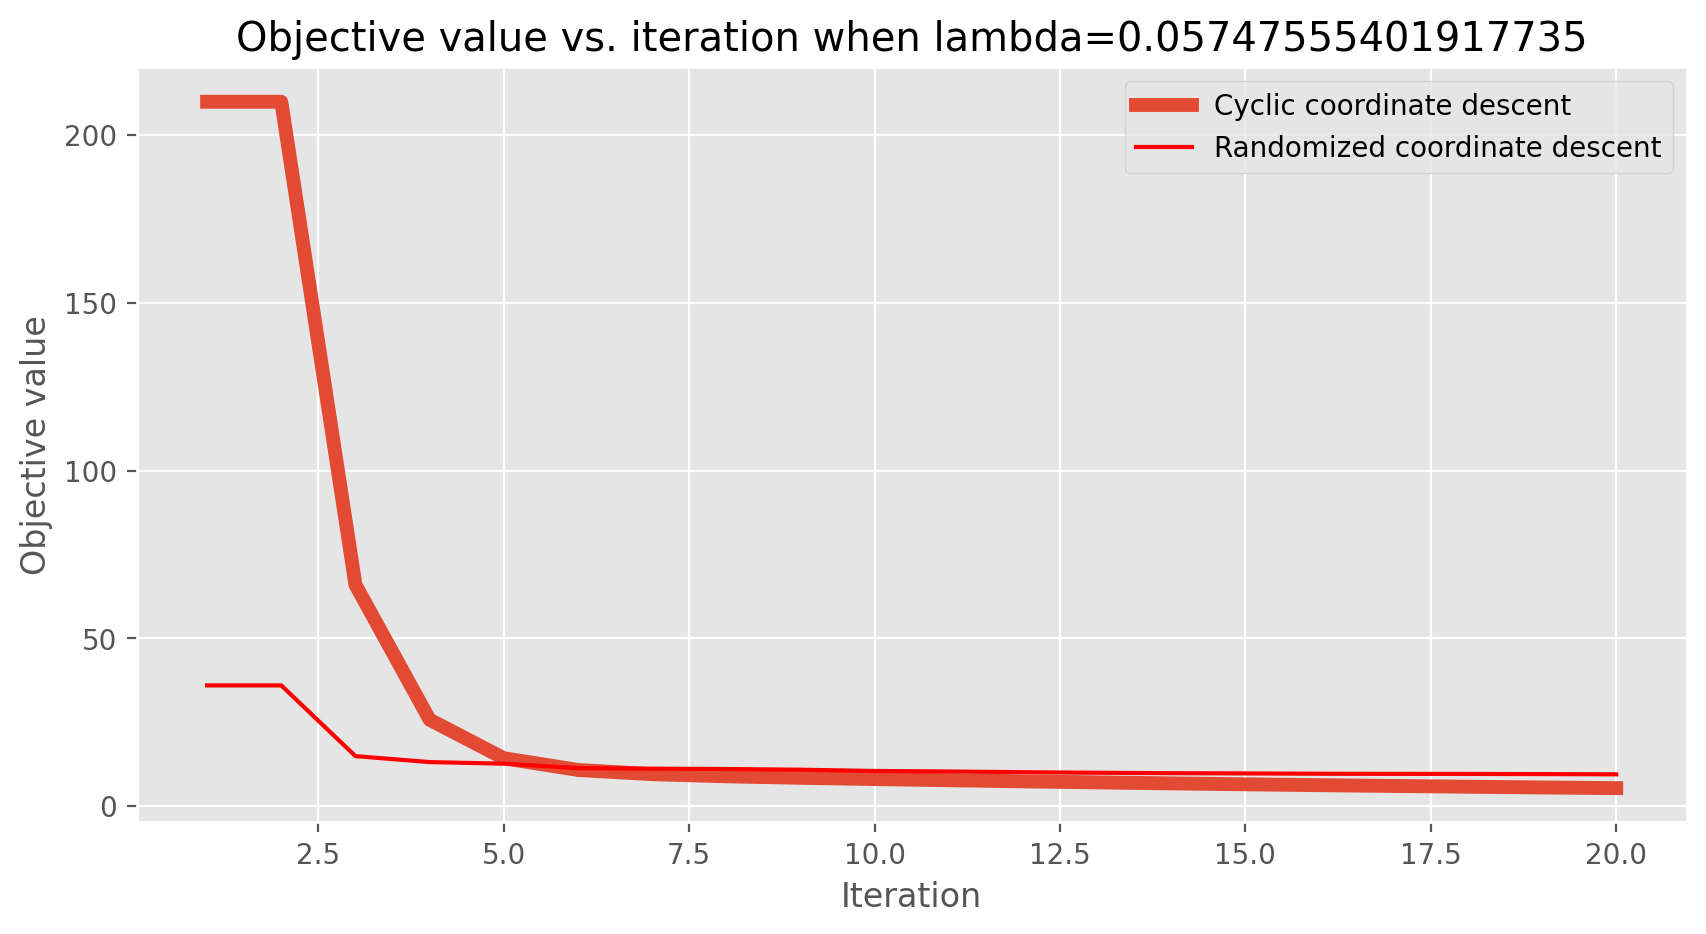

In [24]:
sklearn = Sklearn()
x_train, x_test, y_train, y_test = sklearn.generate_simulate_data()
optimal_alpha, betas_star = sklearn.sklearn_training(x_train, y_train)
algorithm = Algorithm(lambduh=optimal_alpha * 2, beta_star=betas_star, max_iter=1000)
beta_init = np.zeros(np.size(x_train, 1))
betas_cyclic = algorithm.cycliccoorddescent(x_train, y_train, beta_init)
betas_rand = algorithm.randcoorddescent(x_train, y_train, beta_init)
algorithm.objective_plot(betas_cyclic, betas_rand, x_train, y_train, shrink_axis=True)

In [25]:
print("Coefficients trained from sklearn:", betas_star)

Coefficients trained from sklearn: [ 2.0077378   7.58252078 29.57784789  0.          0.          0.
  0.          0.          0.          0.        ]


In [26]:
 print(
        "Coefficients trained from cyclic coordinate descent algorithm:",
        betas_cyclic[-1, :],
    )

Coefficients trained from cyclic coordinate descent algorithm: [ 2.01412555  7.53910544 29.61690458  0.          0.          0.
  0.          0.          0.          0.        ]


In [27]:
print(
        "Coefficients trained from randomized coordinate descent algorithm:",
        betas_rand[-1, :],
    )

Coefficients trained from randomized coordinate descent algorithm: [ 2.01412554  7.53910557 29.61690446  0.          0.          0.
  0.          0.          0.          0.        ]


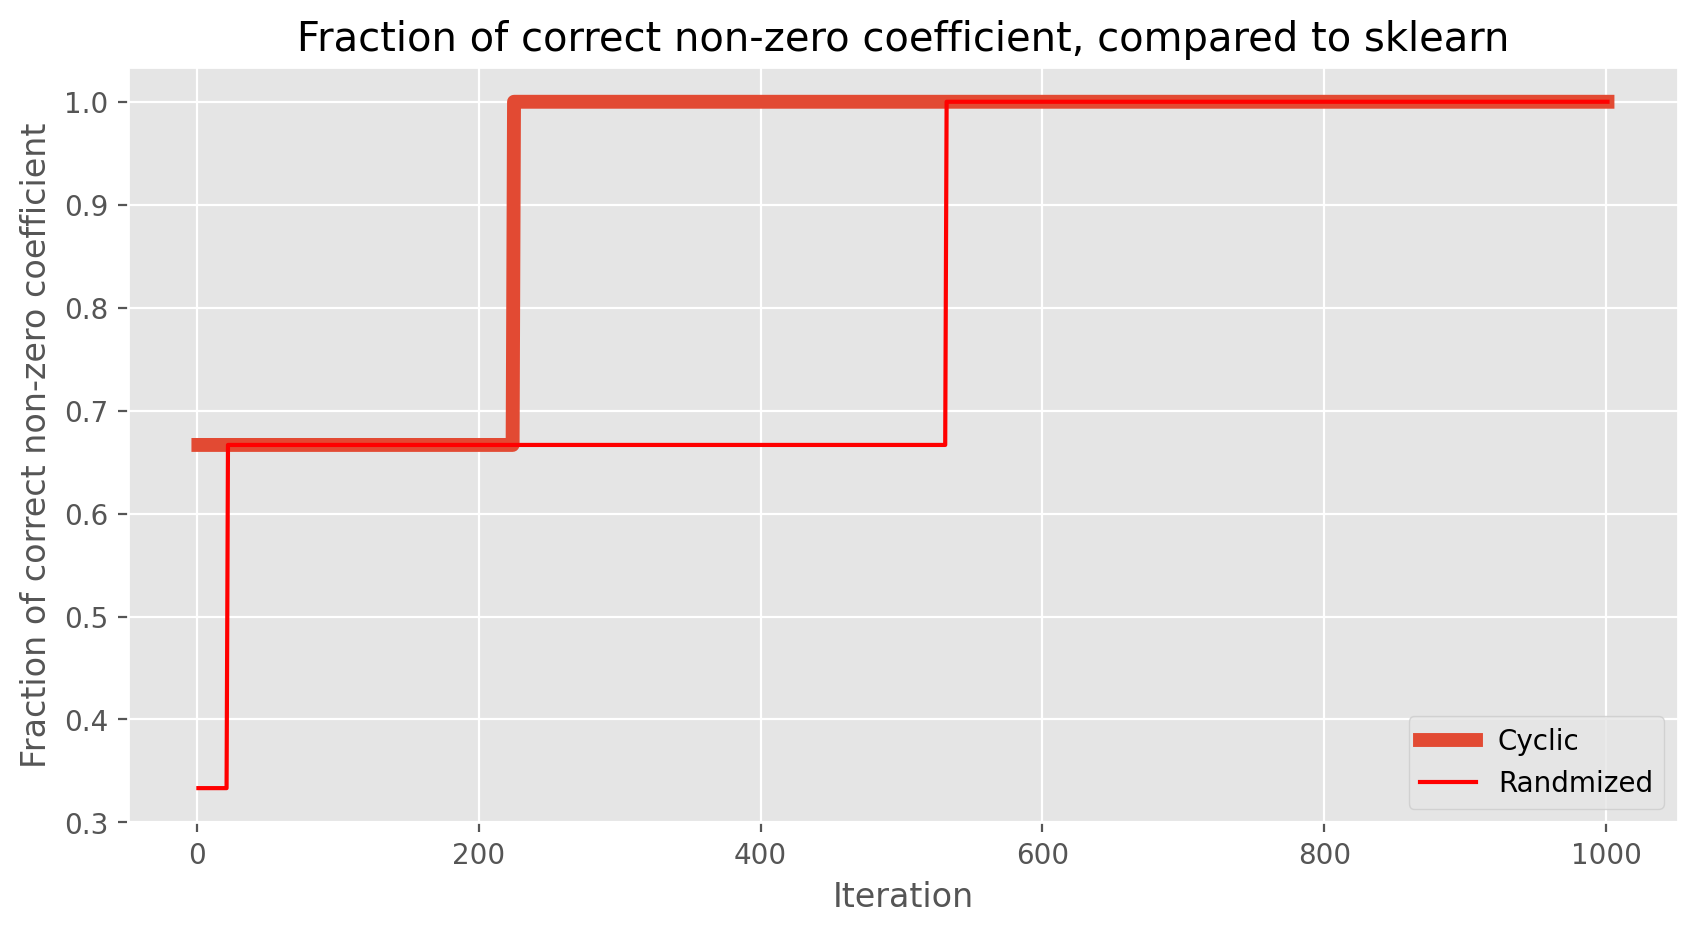

In [28]:
algorithm.plot_correct_coefficient(
        betas_cyclic,
        betas_rand,
        algorithm.fraction_of_correct_non_zero_coefficients,
        "Fraction of correct non-zero coefficient, compared to sklearn",
        "Fraction of correct non-zero coefficient",
    )

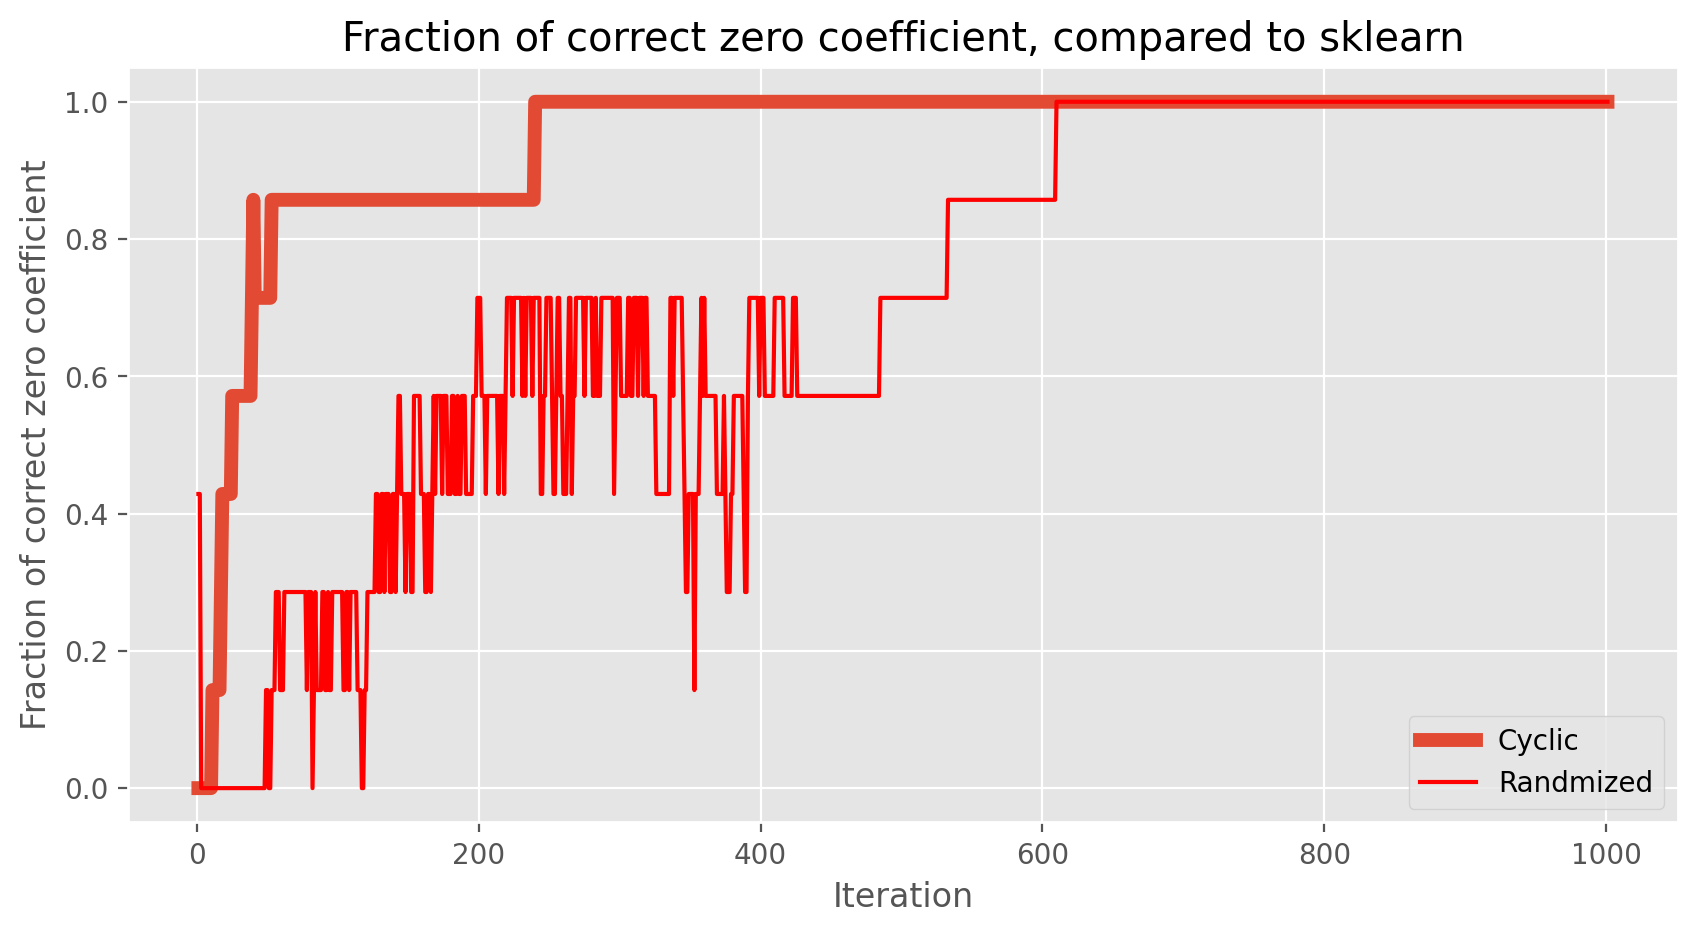

In [29]:
algorithm.plot_correct_coefficient(
        betas_cyclic,
        betas_rand,
        algorithm.fraction_of_correct_zero_coefficients,
        "Fraction of correct zero coefficient, compared to sklearn",
        "Fraction of correct zero coefficient",
    )